In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
covidtotals = pd.read_csv('./data/covidtotalswithmissings.csv')

In [3]:
covidtotals.columns

Index(['iso_code', 'lastdate', 'location', 'total_cases', 'total_deaths',
       'total_cases_pm', 'total_deaths_pm', 'population', 'pop_density',
       'median_age', 'gdp_per_capita', 'hosp_beds'],
      dtype='object')

In [8]:
covidtotals.head()

,iso_code,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
0,AFG,2020-06-01,Afghanistan,15205,257,390.589,6.602,38928341.0,54.422,18.6,1803.987,0.50
1,ALB,2020-06-01,Albania,1137,33,395.093,11.467,2877800.0,104.871,38.0,11803.431,2.89
2,DZA,2020-06-01,Algeria,9394,653,214.225,14.891,43851043.0,17.348,29.1,13913.839,1.90
3,AND,2020-06-01,Andorra,764,51,9888.048,660.066,77265.0,163.755,NaN,NaN,NaN
4,AGO,2020-06-01,Angola,86,4,2.617,0.122,32866268.0,23.890,16.8,5819.495,NaN


In [4]:
totvars = ['location', 'total_cases', 'total_deaths',
       'total_cases_pm', 'total_deaths_pm']

In [5]:
demovars = ['population', 'pop_density',
       'median_age', 'gdp_per_capita', 'hosp_beds']

# 누락값
## 인구통계변수 누락값 확인

In [11]:
#국가별로 누락된 인구통계변수 개수 합산(행 방향) >> 5개 변수중 3개 누락 국가가 10개, 4개 누락 국가가 8개
demovarsmisscnt = covidtotals[demovars].isnull().sum(axis = 1)
demovarsmisscnt.value_counts()

0    156
1     24
2     12
3     10
4      8
dtype: int64

In [7]:
#인구통계열 누락데이터 확인(열 방향)
covidtotals[demovars].isnull().sum(axis = 0)

population         0
pop_density       12
median_age        24
gdp_per_capita    28
hosp_beds         46
dtype: int64

In [15]:
demovarsmisscnt

0      0
1      0
2      0
3      3
4      1
      ..
205    0
206    3
207    0
208    0
209    0
Length: 210, dtype: int64

### index alignment & bool indexing 응용
- 인덱스 값끼리 연산
- 시리즈를 이용해 누락값이 3개 이상인 국가 선별

In [13]:
# 인구통계 데이터 세 개 이상 누락된 국가 나열 >> 인덱스 얼라인먼트 사용
covidtotals.loc[demovarsmisscnt >= 3, ['location', 'iso_code']+demovars].head(5).T

,3,5,24,28,64
location,Andorra,Anguilla,Bonaire Sint Eustatius and Saba,British Virgin Islands,Faeroe Islands
iso_code,AND,AIA,BES,VGB,FRO
population,77265.0,15002.0,26221.0,30237.0,48865.0
pop_density,163.755,NaN,NaN,207.973,35.308
median_age,NaN,NaN,NaN,NaN,NaN
gdp_per_capita,NaN,NaN,NaN,NaN,NaN
hosp_beds,NaN,NaN,NaN,NaN,NaN


In [14]:
type(demovarsmisscnt)

pandas.core.series.Series

## 코로나19 데이터 누락값 확인

In [16]:
# 코로나 데이터에서 누락값 확인 >> 1건(국가)
covidtotals[totvars].isnull().sum(axis = 0)

location           0
total_cases        0
total_deaths       0
total_cases_pm     1
total_deaths_pm    1
dtype: int64

In [19]:
totvarsmisscnt = covidtotals[totvars].isnull().sum(axis = 1)
totvarsmisscnt.value_counts()

0    209
2      1
dtype: int64

In [21]:
# 홍콩 데이터 누락 확인
covidtotals.loc[totvarsmisscnt > 0].T

,87
iso_code,HKG
lastdate,2020-05-26
location,Hong Kong
total_cases,0
total_deaths,0
total_cases_pm,NaN
total_deaths_pm,NaN
population,7496988.0
pop_density,7039.714
median_age,44.8


In [23]:
# 누락 데이터 채우기(fillna)
covidtotals.total_cases_pm.fillna(covidtotals.total_cases/(covidtotals.population/1000000), inplace = True)
covidtotals.total_deaths_pm.fillna(covidtotals.total_deaths/(covidtotals.population/1000000), inplace = True)

In [24]:
covidtotals[totvars].isnull().sum(axis = 0)

location           0
total_cases        0
total_deaths       0
total_cases_pm     0
total_deaths_pm    0
dtype: int64

# 이상값
- 값이 예상대로인지 아닌지 가정을 할 때 변수 분포를 근거로 삼음
- 이상값 식별을 위해 변수의 분포를 먼저 확인해야 함

In [25]:
import statsmodels.api as sm
import scipy.stats as scistat

In [26]:
covidtotals = pd.read_csv('./data/covidtotals.csv')

In [27]:
covidtotals.head()

,iso_code,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
0,AFG,2020-06-01,Afghanistan,15205,257,390.589,6.602,38928341.0,54.422,18.6,1803.987,0.50
1,ALB,2020-06-01,Albania,1137,33,395.093,11.467,2877800.0,104.871,38.0,11803.431,2.89
2,DZA,2020-06-01,Algeria,9394,653,214.225,14.891,43851043.0,17.348,29.1,13913.839,1.90
3,AND,2020-06-01,Andorra,764,51,9888.048,660.066,77265.0,163.755,NaN,NaN,NaN
4,AGO,2020-06-01,Angola,86,4,2.617,0.122,32866268.0,23.890,16.8,5819.495,NaN


In [28]:
covidtotals.set_index('iso_code', inplace = True)

In [30]:
covidtotalsonly = covidtotals.loc[:, totvars]
covidtotalsonly.describe()

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
count,2.100000e+02,210.000000,209.000000,209.000000
mean,2.921614e+04,1770.714286,1361.842909,55.925440
std,1.363978e+05,8705.565857,2629.894101,145.081876
min,0.000000e+00,0.000000,0.894000,0.000000
25%,1.757500e+02,4.000000,96.785000,0.893000
50%,1.242500e+03,25.500000,281.997000,6.214000
75%,1.011700e+04,241.250000,1803.318000,32.158000
max,1.790191e+06,104383.000000,19771.348000,1237.551000


### 백분위수 / 왜도와 첨도 확인

In [31]:
covidtotalsonly.quantile(np.arange(0.0, 1.1, 0.1))

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.0,0.0,0.0,0.8940,0.0000
0.1,22.9,0.0,18.4870,0.0000
0.2,105.2,2.0,56.7386,0.4008
0.3,302.0,6.7,118.2282,1.7348
0.4,762.0,12.0,214.9182,3.9734
0.5,1242.5,25.5,281.9970,6.2140
0.6,2514.6,54.6,546.0534,12.5644
0.7,6959.8,137.2,1074.0324,26.0638
0.8,16847.2,323.2,2208.7374,50.2896
0.9,46513.1,1616.9,3771.9956,139.5290


In [34]:
covidtotalsonly.skew()

total_cases        10.804275
total_deaths        8.929816
total_cases_pm      4.387402
total_deaths_pm     4.663124
dtype: float64

In [35]:
covidtotalsonly.kurt()

total_cases        134.979577
total_deaths        95.737841
total_cases_pm      25.138915
total_deaths_pm     27.105135
dtype: float64

### 정규성 검정
- scipy 라이브러리 >> 샤피로 윌크 검정

In [44]:
def testnorm(var, df):
    stat, p = scistat.shapiro(df[var])
    return p

testnorm('total_cases', covidtotalsonly)

3.753789128593843e-29

In [45]:
testnorm('total_deaths', covidtotalsonly)

4.3427896631016077e-29

In [46]:
testnorm('total_cases_pm', covidtotalsonly)

1.0

In [47]:
testnorm('total_deaths_pm', covidtotalsonly)

1.0

- qq plot(정규 분위수-분위수 그림)

<function matplotlib.pyplot.show(close=None, block=None)>

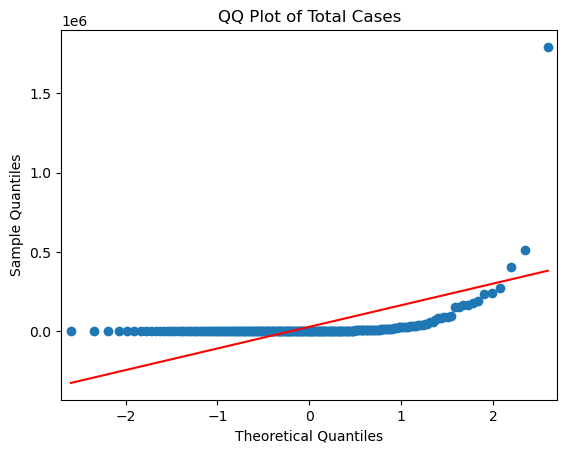

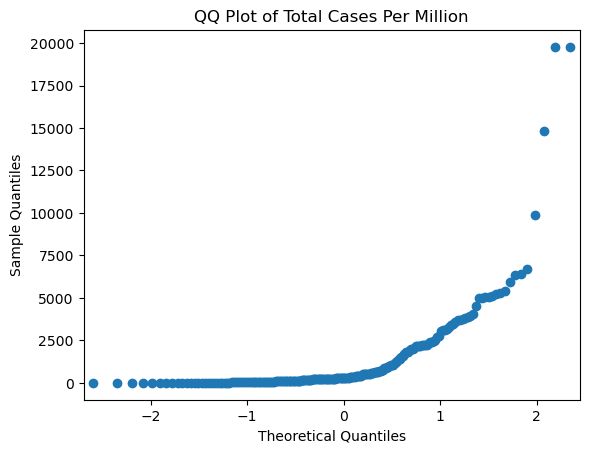

In [54]:
sm.qqplot(covidtotalsonly[['total_cases']].sort_values(['total_cases']), line = 's')
plt.title('QQ Plot of Total Cases')

sm.qqplot(covidtotalsonly[['total_cases_pm']].sort_values(['total_cases_pm']), line = 's')
plt.title('QQ Plot of Total Cases Per Million')
plt.show

- 결과 해석 : 두 변수 모두 정규분포와 크게 다르게 나타남

### 이상값 범위(IQR)

In [56]:
thirdq, firstq = covidtotalsonly.total_cases.quantile(0.75), covidtotalsonly.total_cases.quantile(0.25)
interquantilerange = 1.5 * (thirdq - firstq)
print(interquantilerange)

outlierhigh, outlierlow = interquantilerange + thirdq, firstq - interquantilerange
print(outlierlow, outlierhigh, sep = ' <--> ')

14911.875
-14736.125 <--> 25028.875


### 이상값 데이터만 추출, assign 함수로 컬럼과 상한/하한 확인
- 이상값 데이터프레임을 생성하여, 엑셀에 기록

In [64]:
def getoutliers():
    dfout = pd.DataFrame(columns = covidtotals.columns, data = None)
    for col in covidtotalsonly.columns[1:]:
        thirdq, firstq = covidtotalsonly[col].quantile(0.75), covidtotalsonly[col].quantile(0.25)
        interquantilerange = 1.5 * (thirdq - firstq)
        outlierhigh, outlierlow = interquantilerange + thirdq, firstq - interquantilerange
        
        df = covidtotals.loc[(covidtotals[col] > outlierhigh) | (covidtotals[col] < outlierlow)]
        df = df.assign(varname = col, threshlow = outlierlow, threshhigh = outlierhigh)
        dfout = pd.concat([dfout, df])
    return dfout

In [65]:
outliers = getoutliers()

In [66]:
outliers.varname.value_counts()

total_deaths       36
total_cases        33
total_deaths_pm    28
total_cases_pm     17
Name: varname, dtype: int64

In [71]:
outliers.head(50)

,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds,varname,threshlow,threshhigh
BGD,2020-06-01,Bangladesh,47153,650,286.315,3.947,1.646894e+08,1265.036,27.5,3523.984,0.80,total_cases,-14736.125,25028.875
BLR,2020-06-01,Belarus,42556,235,4503.604,24.870,9.449321e+06,46.858,40.3,17167.967,11.00,total_cases,-14736.125,25028.875
BEL,2020-06-01,Belgium,58381,9467,5037.354,816.852,1.158962e+07,375.564,41.8,42658.576,5.64,total_cases,-14736.125,25028.875
BRA,2020-06-01,Brazil,514849,29314,2422.142,137.910,2.125594e+08,25.040,33.5,14103.452,2.20,total_cases,-14736.125,25028.875
CAN,2020-06-01,Canada,90936,7295,2409.401,193.285,3.774216e+07,4.037,41.4,44017.591,2.50,total_cases,-14736.125,25028.875
CHL,2020-06-01,Chile,99688,1054,5214.841,55.136,1.911621e+07,24.282,35.4,22767.037,2.11,total_cases,-14736.125,25028.875
CHN,2020-06-01,China,84147,4638,58.463,3.222,1.439324e+09,147.674,38.7,15308.712,4.34,total_cases,-14736.125,25028.875
COL,2020-06-01,Colombia,29383,939,577.463,18.454,5.088288e+07,44.223,32.2,13254.949,1.71,total_cases,-14736.125,25028.875
ECU,2020-06-01,Ecuador,39098,3358,2216.055,190.330,1.764306e+07,66.939,28.1,10581.936,1.50,total_cases,-14736.125,25028.875
FRA,2020-06-01,France,151753,28802,2324.879,441.251,6.527351e+07,122.578,42.0,38605.671,5.98,total_cases,-14736.125,25028.875
